<center>
<a href="http://uf-mi.u-bordeaux.fr/MSS/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/logo_MAS_MSS.jpg" style="float:left; max-width: 400px; display: inline" alt="INSA"/></a>

<a href="https://www.math.u-bordeaux.fr/" ><img src="https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/LogoIMB.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# Classification d'images avec des réseaux de neurons profonds
<a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 150px; display: inline" alt="Python"/></a> &<a href="https://pytorch.org/">
    <img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.png" style="width: 100px; height: 100px; transform: scale(0.1);" alt="PyTorch"/>
</a>

Auteurs :   Fama (MSS)
            Otschapowski Iliana (MSS)

# Introduction

L'objectif de ce projet est de créer le modèle le plus performant possible pour détecter la présence ou non d'éoliennes sur des images. Nous devons donc créer un modèle de réseau de neurones de classification binaire. Pour cela nous avons à disposition 2 jeux de données : un petit et le complet (beaucoup plus conséquent). Nous entrainerons nos différents modèles à l'aide du jeu de données "small", puis après avoir choisi nos 2 meilleurs modèles, nous les entrainerons sur le vrai jeu de données.

Nous avons testé différents modèles, dans ce notebook nous avons laissé que les modèles qui nous semblaient corrects. Cependant nous n'avons pu tester sur le gros jeu de données que le modèle fait à la main à cause du problème de gpu sur Mac.

# 1 - Pré-traitement des données et fonctions

In [ ]:
import zipfile
import urllib.request

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from tempfile import TemporaryDirectory
from tqdm import tqdm
import warnings

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Chemin d'accès aux données dans Google Drive
data_dir_fama = '/Users/Desktop/APDSD/Small'

## 1.1 Pré-traitement des données

On définit les paramètres constants, ainsi que les transformations que l'on veut appliquer à nos données d'apprentissage d'une part, pour éviter le sur-apprentissage, et d'autre part, les transformations que l'on souhaite appliquer à nos données de validation.

In [ ]:
# Paramètres
nb_classes = 2
batch_size = 36
img_width = 128
img_height = 128

# Chemin d'accès aux données
data_dir = '/Users/Desktop/APDSD/Small'

# Définir les transformations pour normaliser les images
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),# Redimensionner les images
        transforms.RandomHorizontalFlip(),           # Retourner horizontalement (éviter le sur-apprentissage)
        transforms.RandomRotation(20),               # Rotation aléatoire (éviter le sur-apprentissage)
#        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #modifie la luminosité, le contraste, la saturation (éviter le sur-apprentissage)
        transforms.ToTensor(),  # Convertir les images en tenseur PyTorch
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliser les images
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Charger les ensembles d'entraînement et de validation
train_dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(data_dir + '/validation', transform=data_transforms['val'])

# Créer les DataLoaders pour charger les images par lots
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Obtenir les classes
class_names = train_dataset.classes
print(f"Classes: {class_names}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Classes: ['other', 'target']
cpu


## 1.2 Fonctions d'entrainement de modèle et d'affichage de graphes

On définit une fonction permettant d'entraîner le modèle. Cette fonction donne aussi la meilleure accuracy parmi toutes les époques. Deux fonctions légèrement différentes ont été faites car dans un premier temps nous avons fait des modèles à 2 couches de sorties, puis une. Ainsi les méthodes de prédiction sont différentes

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs):
    since = time.time()

    # Dictionnaires pour stocker les pertes et les précisions par époque
    history = {
        "train_loss": [],
        "train_acc": [],
        "validation_loss": [],
        "validation_acc": []
    }

    # Créer un fichier temporaire pour sauvegarder les meilleurs poids du modèle
    best_model_weights_path = 'best_model_weights.pt'
    best_acc = 0.0

    for epoch in range(num_epochs): #boucle sur les époques
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Phase d'entraînement et de validation
        for phase in ['train', 'validation']: #boucle sur les données d'apprentissage et de validation
            if phase == 'train':
                model.train()  # Mettre le modèle en mode entraînement
                dataloader = train_loader
            else:
                model.eval()   # Mettre le modèle en mode évaluation
                dataloader = val_loader

            running_loss = 0.0 #compteur à 0
            running_corrects = 0

            # Itérer sur les données
            for inputs, labels in dataloader: #boucle sur les images
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Remettre les gradients à zéro
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #prédiction des classes avec la pluq haute proba
                    loss = criterion(outputs, labels) #calcule de la perte

                    # Backward + optimisation seulement si en phase d'entraînement
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculer la perte et le nombre de prédictions correctes
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step du scheduler à la fin de chaque époque en phase d'entraînement
            if phase == 'train':
                scheduler.step()

            # Calcul de la perte et de la précision de l'époque
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Stocker les résultats dans le dictionnaire history
            if phase == 'train':
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["validation_loss"].append(epoch_loss)
                history["validation_acc"].append(epoch_acc.item())

            # Sauvegarder les meilleurs poids du modèle si la précision de validation est meilleure
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # Sauvegarder les poids du modèle avec la meilleure précision de validation
                torch.save(model.state_dict(), best_model_weights_path)

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    print(f'Best val Acc: {best_acc:.4f}')

    # Charger les meilleurs poids du modèle
    model.load_state_dict(torch.load(best_model_weights_path))

    # Retourner le modèle et l'historique
    return model, history


In [ ]:
def train_model_2(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs):
    since = time.time()
    # Dictionnaires pour stocker les pertes et les précisions par époque
    history = {
        "train_loss": [],
        "train_acc": [],
        "validation_loss": [],
        "validation_acc": []
    }

    # Créer un fichier temporaire pour sauvegarder les meilleurs poids du modèle
    best_model_weights_path = 'best_model_weights.pt'
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Phase d'entraînement et de validation
        for phase in ['train', 'validation']: #boucle sur les données d'apprentissage et de validation
            if phase == 'train':
                model.train()  # Mettre le modèle en mode entraînement
                dataloader = train_loader
            else:
                model.eval()   # Mettre le modèle en mode évaluation
                dataloader = val_loader

            running_loss = 0.0 #compteur à 0
            running_corrects = 0

            # Itérer sur les données
            for inputs, labels in dataloader: #boucle sur les images
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)  # Redimensionner les labels

                # Remettre les gradients à zéro
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs) > 0.5  # Seuil de 0.5 pour la classification binaire
                    loss = criterion(outputs, labels) #calcule de la perte

                    # Backward + optimisation seulement si en phase d'entraînement
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculer la perte et le nombre de prédictions correctes
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step du scheduler à la fin de chaque époque en phase d'entraînement
            if phase == 'train':
                scheduler.step()

            # Calcul de la perte et de la précision de l'époque
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Stocker les résultats dans le dictionnaire history
            if phase == 'train':
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["validation_loss"].append(epoch_loss)
                history["validation_acc"].append(epoch_acc.item())

            # Sauvegarder les meilleurs poids du modèle si la précision de validation est meilleure
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # Sauvegarder les poids du modèle avec la meilleure précision de validation
                torch.save(model.state_dict(), best_model_weights_path)

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    print(f'Best val Acc: {best_acc:.4f}')

    # Charger les meilleurs poids du modèle
    model.load_state_dict(torch.load(best_model_weights_path))

    # Retourner le modèle et l'historique
    return model, history


On définit maintenant une fonction permettant d'afficher la précision et la perte (d'apprentissage et de validation) du modèle considéré

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, title_suffix=""):
    # Créer la figure
    plt.figure(figsize=(8, 8))

    # Tracer la précision d'entraînement et de validation
    plt.subplot(2, 1, 1)
    plt.plot(history["train_acc"], label='Training Accuracy')
    plt.plot(history["validation_acc"], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title(f'Training and Validation Accuracy {title_suffix}')

    # Tracer la perte d'entraînement et de validation
    plt.subplot(2, 1, 2)
    plt.plot(history["train_loss"], label='Training Loss')
    plt.plot(history["validation_loss"], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0, max(max(history["train_loss"]), max(history["validation_loss"]))])
    plt.title(f'Training and Validation Loss {title_suffix}')
    plt.xlabel('Epoch')

    # Afficher le graphique
    plt.tight_layout()
    plt.show()

# 2 Modèle CNN (convolutionnal neural network)

Après avoir effectué des modèles de neurones très simples, nous avons mis au point des modèles convolutionnels. Nous avons joué sur le nombres de couches, l'ajout de MaxPool2d après chaque couche ou non et d'autres paramètres. C'est finalement le modèle suivant, le plus optimal, que nous avons gardé. Nous avons dans un premier temps regardé sur le petit jeu de données.

In [ ]:
# Définition du modèle
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        #détecte les motifs, 3 neurones d'entrée (RGB), sortie de 32 neurones
        self.bn1 = nn.BatchNorm2d(32)
        #applique une normalisation aux activations de sortie de la couche prédécente d'où le 32

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling 2x2 (diminue la résolution mais garde les infos les plus importantes)

#        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling 2x2

        # Couche entièrement connectée et de sortie avec LazyLinear
        self.flatten = nn.Flatten() #vecteur 1D
        self.fc1 = nn.LazyLinear(128) #couche dense
        self.bn_fc1 = nn.BatchNorm1d(128) #batch normalisation
        self.dropout = nn.Dropout(0.5) #évite l'overfitting
        self.fc2 = nn.Linear(128, num_classes) #sortie de taille 2

        # Activation LeakyReLU
        self.leaky_relu = nn.LeakyReLU() #évite les neurones "morts"

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
      #  x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# Instancier le modèle, l'optimiseur et la fonction de perte
model_cnn = CNNModel(num_classes=2)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs=10

model_CNN, history_CNN = train_model(
    model=model_cnn,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=num_epochs
)

Epoch 0/9
----------
train Loss: 0.5764 Acc: 0.7035
validation Loss: 0.6651 Acc: 0.5500

Epoch 1/9
----------
train Loss: 0.2965 Acc: 0.8801
validation Loss: 0.5421 Acc: 0.7000

Epoch 2/9
----------
train Loss: 0.2189 Acc: 0.9180
validation Loss: 0.3841 Acc: 0.8600

Epoch 3/9
----------
train Loss: 0.1794 Acc: 0.9464
validation Loss: 0.3164 Acc: 0.8600

Epoch 4/9
----------
train Loss: 0.1588 Acc: 0.9590
validation Loss: 0.2838 Acc: 0.9000

Epoch 5/9
----------
train Loss: 0.1348 Acc: 0.9527
validation Loss: 0.2598 Acc: 0.9000

Epoch 6/9
----------
train Loss: 0.1067 Acc: 0.9716
validation Loss: 0.2874 Acc: 0.8900

Epoch 7/9
----------
train Loss: 0.1093 Acc: 0.9653
validation Loss: 0.2863 Acc: 0.8800

Epoch 8/9
----------
train Loss: 0.0914 Acc: 0.9779
validation Loss: 0.2772 Acc: 0.9000

Epoch 9/9
----------
train Loss: 0.1110 Acc: 0.9748
validation Loss: 0.2717 Acc: 0.9000

Training complete in 1m 32s
Best val Acc: 0.9000


Comme la précision et la perte se stabilisent assez rapidement, nous n'avons gardé que 5 époques pour tester sur le vrai jeu de données.

In [ ]:
# Paramètres
nb_classes = 2
batch_size = 36
img_width = 128
img_height = 128

# Chemin d'accès aux données
data_dir = '/Users/Desktop/APDSD/Data_Projet_1_Defi_IA'

# Définir les transformations pour normaliser les images
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),# Redimensionner les images
        transforms.RandomHorizontalFlip(),           # Retourner horizontalement (éviter le sur-apprentissage)
        transforms.RandomRotation(20),               # Rotation aléatoire (éviter le sur-apprentissage)
#        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #modifie la luminosité, le contraste, la saturation (éviter le sur-apprentissage)
        transforms.ToTensor(),  # Convertir les images en tenseur PyTorch
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliser les images
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Charger les ensembles d'entraînement et de validation
train_dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(data_dir + '/validation', transform=data_transforms['val'])

# Créer les DataLoaders pour charger les images par lots
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Obtenir les classes
class_names = train_dataset.classes
print(f"Classes: {class_names}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Classes: ['other', 'target']
cpu


In [ ]:
# Définition du modèle
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        # Couches de convolution avec BatchNorm et LeakyReLU
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling 2x2

#        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling 2x2

        # Couche entièrement connectée et de sortie avec LazyLinear
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

        # Activation LeakyReLU
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
      #  x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.leaky_relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instancier le modèle, l'optimiseur et la fonction de perte
model_cnn = CNNModel(num_classes=2)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs=5

model_CNN, history_CNN = train_model(
    model=model_cnn,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=num_epochs
)


Epoch 0/4
----------
train Loss: 0.1977 Acc: 0.9258
validation Loss: 0.1478 Acc: 0.9434

Epoch 1/4
----------
train Loss: 0.1528 Acc: 0.9448
validation Loss: 0.1326 Acc: 0.9478

Epoch 2/4
----------
train Loss: 0.1362 Acc: 0.9521
validation Loss: 0.1131 Acc: 0.9568

Epoch 3/4
----------
train Loss: 0.1270 Acc: 0.9549
validation Loss: 0.1208 Acc: 0.9540

Epoch 4/4
----------
train Loss: 0.1189 Acc: 0.9587
validation Loss: 0.1100 Acc: 0.9574

Training complete in 171m 12s
Best val Acc: 0.9574


Le modèle a mis environ 2h et 50 minutes a tourner soit 34 minutes par époque en moyenne. De même que sur le petit jeu de données on obtient très rapidement de bon résultats qui sont stables pour la précision. La perte s'améliore avec les époques mais se stabilise un peu moins que la précision.

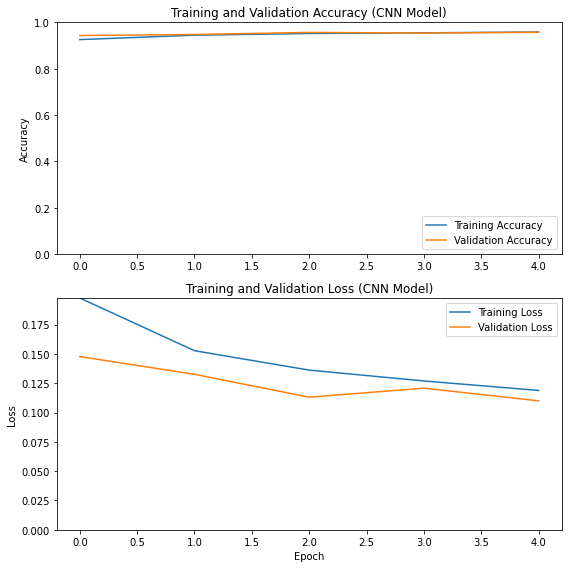

In [ ]:
# Utilisation de la fonction avec un dictionnaire d'historique
plot_learning_curves(history_CNN, title_suffix="(CNN Model)")

Les prochains modèles n'ont été exécutés que sur le petit jeu de données "small" car le gpu n'est disponible sur mac, et avec le cpu les temps d'exécution étaient beaucoup trop longs (plusieurs jours).

In [ ]:
# Chemin d'accès aux données
data_dir = '/Users/Desktop/APDSD/Small'

# Définir les transformations pour normaliser les images
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_width, img_height)),# Redimensionner les images
        transforms.RandomHorizontalFlip(),           # Retourner horizontalement (éviter le sur-apprentissage)
        transforms.RandomRotation(20),               # Rotation aléatoire (éviter le sur-apprentissage)
#        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), #modifie la luminosité, le contraste, la saturation (éviter le sur-apprentissage)
        transforms.ToTensor(),  # Convertir les images en tenseur PyTorch
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliser les images
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Charger les ensembles d'entraînement et de validation
train_dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(data_dir + '/validation', transform=data_transforms['val'])

# Créer les DataLoaders pour charger les images par lots
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Obtenir les classes
class_names = train_dataset.classes
print(f"Classes: {class_names}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# 3 Modèle Mobil net

Nous avons ensuite testé un modèle pré entrainé, le mobilenetv2 vu en cours.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# Charger le modèle MobileNet V2 pré-entraîné
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Désactiver l'apprentissage pour les paramètres de la base convolutive
for param in model.features.parameters():
    param.requires_grad = False

# Remplacer la dernière couche de classification pour une tâche binaire
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, 1)  # Sortie de 1 pour la classification binaire (éolienne ou non)
)

# Déplacer le modèle sur le périphérique GPU (si disponible)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCEWithLogitsLoss()  # Adapté pour la classification binaire
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)


 Entraînement du modèle

Epoch 1/20
Training loss: 0.6581, accuracy: 0.5994
Validation loss: 0.6423, accuracy: 0.6500
Epoch 2/20
Training loss: 0.6326, accuracy: 0.6782
Validation loss: 0.6309, accuracy: 0.6600
Epoch 3/20
Training loss: 0.6183, accuracy: 0.6782
Validation loss: 0.6209, accuracy: 0.6800
Epoch 4/20
Training loss: 0.6071, accuracy: 0.6972
Validation loss: 0.6076, accuracy: 0.6200
Epoch 5/20
Training loss: 0.5866, accuracy: 0.7003
Validation loss: 0.5964, accuracy: 0.6500
Epoch 6/20
Training loss: 0.5922, accuracy: 0.6972
Validation loss: 0.5907, accuracy: 0.6700
Epoch 7/20
Training loss: 0.5772, accuracy: 0.7161
Validation loss: 0.5875, accuracy: 0.6600
Epoch 8/20
Training loss: 0.5600, accuracy: 0.7445
Validation loss: 0.5855, accuracy: 0.6500
Epoch 9/20
Training loss: 0.5519, accuracy: 0.7445
Validation loss: 0.5796, accuracy: 0.6300
Epoch 10/20
Training loss: 0.5511, accuracy: 0.7792
Validation loss: 0.5733, accuracy: 0.6500
Epoch 11/20
Training loss: 0.5411, accuracy: 0.7729
Validation loss: 

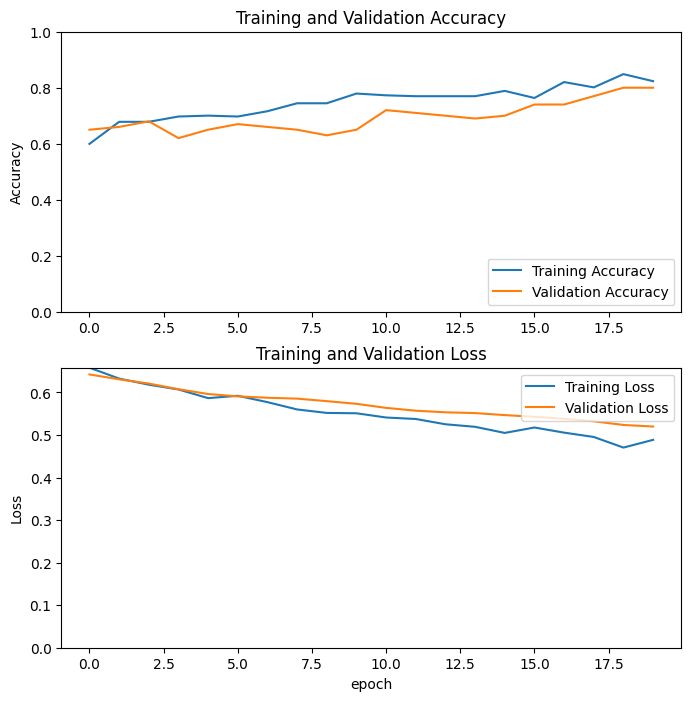

In [ ]:
# Hyperparamètres
num_epochs = 20

model_MN,history_MN=train_model_2(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs)
plot_learning_curves(history_MN, title_suffix="(CNN Model)")

Déblocage de certaines couches pour le fine-tuning

In [ ]:
# Débloquer les 100 premières couches pour le fine-tuning
layer_count = 0
for child in model.features.children():
    for param in child.parameters():
        param.requires_grad = (layer_count < 200)  # Débloque les 100 premières couches
        layer_count += 1

# Affichage des couches débloquées pour vérification
print(f"Total layers in the model: {layer_count}")
for name, param in model.named_parameters():
    print(f"{name} - requires_grad = {param.requires_grad}")


Total layers in the model: 156
features.0.0.weight - requires_grad = True
features.0.1.weight - requires_grad = True
features.0.1.bias - requires_grad = True
features.1.conv.0.0.weight - requires_grad = True
features.1.conv.0.1.weight - requires_grad = True
features.1.conv.0.1.bias - requires_grad = True
features.1.conv.1.weight - requires_grad = True
features.1.conv.2.weight - requires_grad = True
features.1.conv.2.bias - requires_grad = True
features.2.conv.0.0.weight - requires_grad = True
features.2.conv.0.1.weight - requires_grad = True
features.2.conv.0.1.bias - requires_grad = True
features.2.conv.1.0.weight - requires_grad = True
features.2.conv.1.1.weight - requires_grad = True
features.2.conv.1.1.bias - requires_grad = True
features.2.conv.2.weight - requires_grad = True
features.2.conv.3.weight - requires_grad = True
features.2.conv.3.bias - requires_grad = True
features.3.conv.0.0.weight - requires_grad = True
features.3.conv.0.1.weight - requires_grad = True
features.3.con

Définir un optimiseur avec un taux d’apprentissage plus faible pour le fine-tuning

In [ ]:
# Définir un optimiseur avec un taux d'apprentissage réduit
optimizer = optim.RMSprop(model.parameters(), lr=0.00001)


 Entraînement avec le fine-tuning

In [ ]:
# Continuer l'entraînement avec le fine-tuning
fine_tune_epochs = 20
total_epochs = num_epochs + fine_tune_epochs

model_MN_ft,history_MN_ft=train_model_2(model, criterion, optimizer, scheduler, train_loader, val_loader, device,fine_tune_epochs)

Epoch 21/40
Training loss: 0.4207, accuracy: 0.8864
Validation loss: 0.3500, accuracy: 0.9100
Epoch 22/40
Training loss: 0.2457, accuracy: 0.9653
Validation loss: 0.3017, accuracy: 0.9100
Epoch 23/40
Training loss: 0.1894, accuracy: 0.9748
Validation loss: 0.2747, accuracy: 0.9000
Epoch 24/40
Training loss: 0.1387, accuracy: 0.9937
Validation loss: 0.2566, accuracy: 0.9000
Epoch 25/40
Training loss: 0.1151, accuracy: 0.9968
Validation loss: 0.2498, accuracy: 0.9000
Epoch 26/40
Training loss: 0.0973, accuracy: 1.0000
Validation loss: 0.2427, accuracy: 0.9200
Epoch 27/40
Training loss: 0.0950, accuracy: 1.0000
Validation loss: 0.2413, accuracy: 0.9100
Epoch 28/40
Training loss: 0.0834, accuracy: 0.9968
Validation loss: 0.2411, accuracy: 0.9000
Epoch 29/40
Training loss: 0.0664, accuracy: 0.9968
Validation loss: 0.2421, accuracy: 0.9000
Epoch 30/40
Training loss: 0.0540, accuracy: 1.0000
Validation loss: 0.2373, accuracy: 0.9200
Epoch 31/40
Training loss: 0.0499, accuracy: 1.0000
Validati

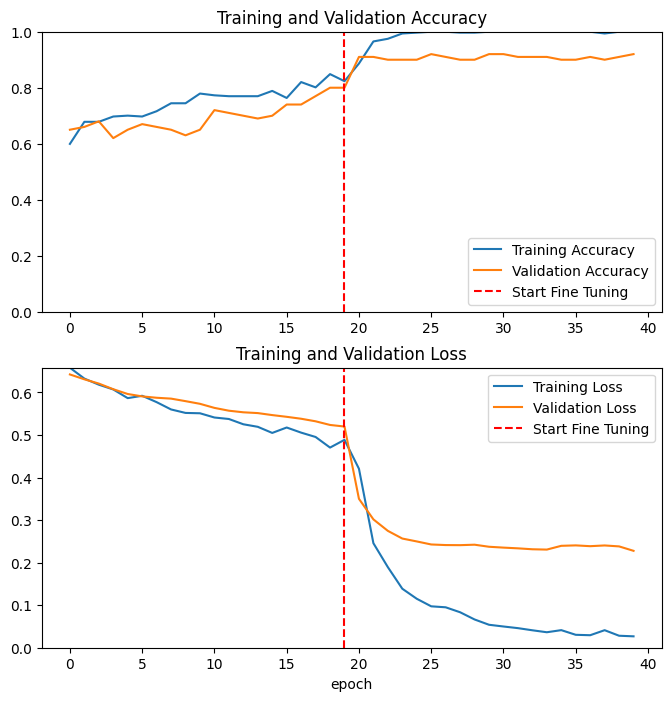

In [ ]:
# Tracer les courbes d'apprentissage
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(total_epochs), train_acc_history, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc_history, label='Validation Accuracy')
plt.ylim([0, 1])
plt.axvline(x=num_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(range(total_epochs), train_loss_history, label='Training Loss')
plt.plot(range(total_epochs), val_loss_history, label='Validation Loss')
plt.ylim([0, max(max(train_loss_history), max(val_loss_history))])
plt.axvline(x=num_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Ce modèle a une assez bonne précision, cependant il est assez instable et la perte de validation est trop élevée par rapport à celle d'apprentissage.

Validation accuracy: 0.92
Predictions:
 [ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False  True False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True False  True
  True  True False False]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


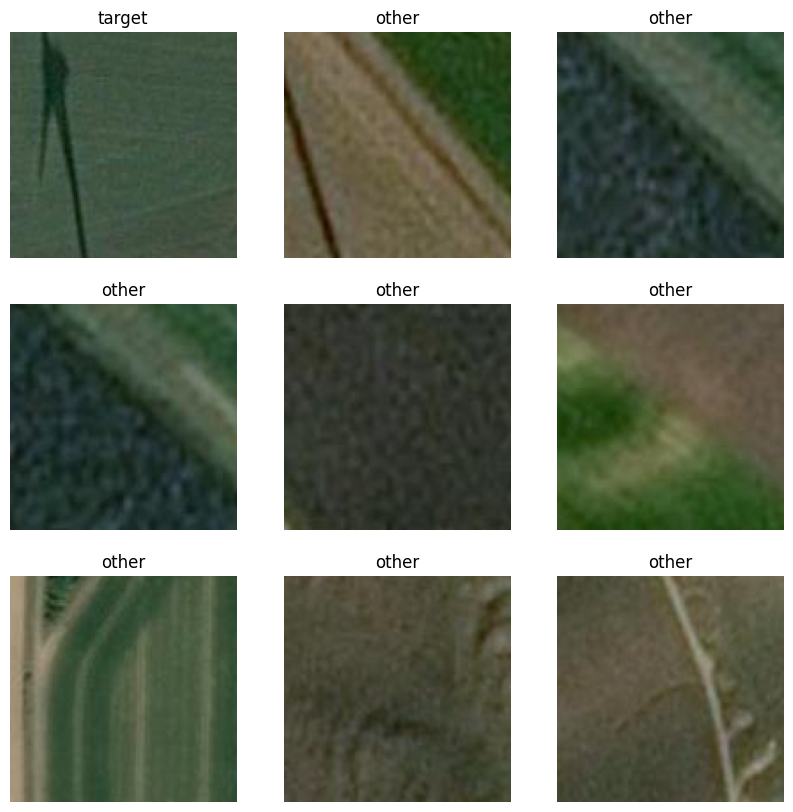

In [ ]:
# Évaluer le modèle sur l'ensemble de validation
model.eval()
val_running_corrects = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5

        val_running_corrects += torch.sum(preds == labels.byte())

val_accuracy = val_running_corrects.double() / len(val_dataset)
print('Validation accuracy:', val_accuracy.item())

# Prédictions sur un lot d'images de validation
inputs, labels = next(iter(val_loader))
inputs = inputs.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs) > 0.5

print('Predictions:\n', preds.cpu().numpy().flatten())
print('Labels:\n', labels.cpu().numpy())

# Affichage des images avec les prédictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = inputs[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Dénormaliser
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(class_names[int(preds[i].item())])
    plt.axis("off")
plt.show()


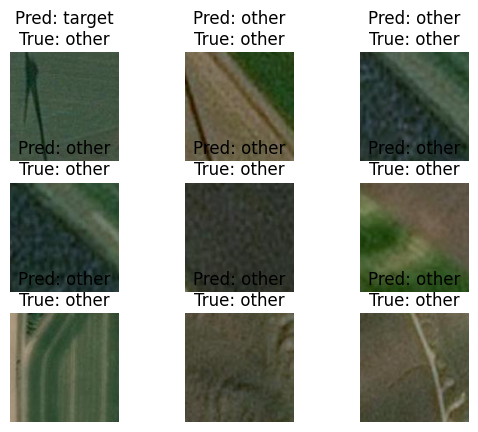

In [ ]:
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = inputs[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    pred_label = class_names[int(preds[i].item())]
    true_label = class_names[int(labels[i].item())]
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()


In [ ]:
# Préparation des données de test
test_dataset = datasets.ImageFolder(prediction_dir, transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Liste pour stocker les prédictions et noms d'images
predictions = []
img_names = []

# Prédictions
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) > 0.5).int()
        predictions.append(predicted.item())

# Extraction des noms des fichiers d'images
file_paths = [sample[0] for sample in test_dataset.samples]
img_names = [os.path.basename(path) for path in file_paths]

# Création du fichier CSV
results_df = pd.DataFrame({'name': img_names, 'prediction': predictions})
results_df.to_csv('predictions.csv', index=False, sep=';')


Bien que le modèle MobileNet semble relativement efficace, il existe des modèles encore mieux adapté à la classification d'images binaire. Nous avons étudié le modèle pré entrainé EfficientNetB3 et ResNet50.

# 4 EfficientNetB3 pré-entraîné sur ImageNet

In [ ]:
from torchvision import models
import torch.nn as nn

# Chargement du modèle EfficientNetB3
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

# Adapter la dernière couche pour une classification binaire
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 1)  # Sortie de 1 pour une classification binaire
)

# Déplacement sur GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch.optim as optim

# Fonction de perte
criterion = nn.BCEWithLogitsLoss()

# Optimiseur AdamW avec scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


### Entraînement Initial

In [ ]:
num_epochs = 15
model_EN,history_EN=train_2(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs)

plot_learning_curves(history_EN, title_suffix="(CNN Model)")

Epoch 1/15, Train Loss: 0.7028, Acc: 0.4890, Val Loss: 0.6823, Val Acc: 0.5900
Epoch 2/15, Train Loss: 0.6317, Acc: 0.7192, Val Loss: 0.6600, Val Acc: 0.6900
Epoch 3/15, Train Loss: 0.5816, Acc: 0.8517, Val Loss: 0.6254, Val Acc: 0.7400
Epoch 4/15, Train Loss: 0.5483, Acc: 0.8864, Val Loss: 0.5868, Val Acc: 0.7800
Epoch 5/15, Train Loss: 0.5187, Acc: 0.9180, Val Loss: 0.5541, Val Acc: 0.8800
Epoch 6/15, Train Loss: 0.4670, Acc: 0.9369, Val Loss: 0.5230, Val Acc: 0.8900
Epoch 7/15, Train Loss: 0.4266, Acc: 0.9432, Val Loss: 0.4937, Val Acc: 0.9100
Epoch 8/15, Train Loss: 0.3848, Acc: 0.9685, Val Loss: 0.4624, Val Acc: 0.9000
Epoch 9/15, Train Loss: 0.3513, Acc: 0.9685, Val Loss: 0.4260, Val Acc: 0.9100
Epoch 10/15, Train Loss: 0.3138, Acc: 0.9748, Val Loss: 0.3961, Val Acc: 0.9100
Epoch 11/15, Train Loss: 0.2561, Acc: 0.9842, Val Loss: 0.3619, Val Acc: 0.9100
Epoch 12/15, Train Loss: 0.2242, Acc: 0.9905, Val Loss: 0.3332, Val Acc: 0.9100
Epoch 13/15, Train Loss: 0.1970, Acc: 0.9874, Val

### Fine-Tuning (Débloquer Plus de Couches)

In [ ]:
# Débloquer plus de couches pour le fine-tuning
for param in model.features.parameters():
    param.requires_grad = True

# Entraînement de fine-tuning
fine_tune_epochs = 10
model_EN_ft,history_EN_ft=train_model_2(model, criterion, optimizer, scheduler, train_loader, val_loader, device,fine_tune_epochs)

Epoch 1/10, Train Loss: 0.1166, Acc: 0.9905, Val Loss: 0.2589, Val Acc: 0.9000
Epoch 2/10, Train Loss: 0.1047, Acc: 0.9968, Val Loss: 0.2416, Val Acc: 0.9100
Epoch 3/10, Train Loss: 0.0904, Acc: 0.9968, Val Loss: 0.2324, Val Acc: 0.9000
Epoch 4/10, Train Loss: 0.0797, Acc: 1.0000, Val Loss: 0.2239, Val Acc: 0.9000
Epoch 5/10, Train Loss: 0.0652, Acc: 1.0000, Val Loss: 0.2169, Val Acc: 0.9100
Epoch 6/10, Train Loss: 0.0545, Acc: 1.0000, Val Loss: 0.2111, Val Acc: 0.9200
Epoch 7/10, Train Loss: 0.0449, Acc: 1.0000, Val Loss: 0.2091, Val Acc: 0.9300
Epoch 8/10, Train Loss: 0.0492, Acc: 1.0000, Val Loss: 0.2041, Val Acc: 0.9000
Epoch 9/10, Train Loss: 0.0382, Acc: 1.0000, Val Loss: 0.1940, Val Acc: 0.9100
Epoch 10/10, Train Loss: 0.0321, Acc: 1.0000, Val Loss: 0.1874, Val Acc: 0.9100


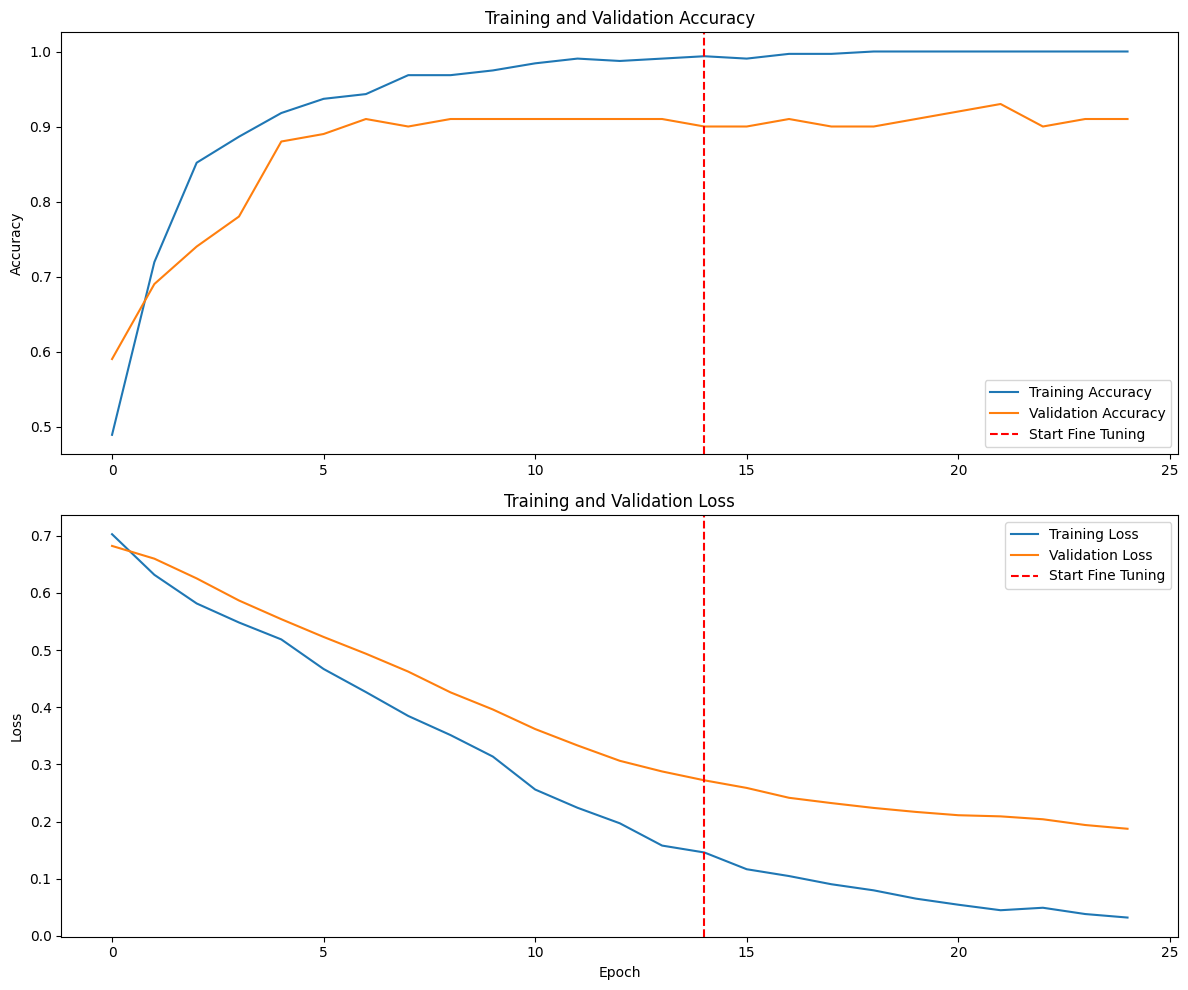

In [ ]:
import matplotlib.pyplot as plt

# Affichage des courbes de précision et de perte
plt.figure(figsize=(12, 10))

# Sous-graphe de précision
plt.subplot(2, 1, 1)
plt.plot(range(len(train_acc_history)), train_acc_history, label='Training Accuracy')
plt.plot(range(len(val_acc_history)), val_acc_history, label='Validation Accuracy')
plt.axvline(x=num_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

# Sous-graphe de perte
plt.subplot(2, 1, 2)
plt.plot(range(len(train_loss_history)), train_loss_history, label='Training Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
plt.axvline(x=num_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


On obtient un modèle plus stable et avec une meilleure perte que le modèle MobileNet

### Évaluation du Modèle sur l’Ensemble de Validation

In [ ]:
# Évaluation finale sur l'ensemble de validation
model.eval()
val_running_corrects = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        val_running_corrects += torch.sum(preds == labels.byte())

val_accuracy = val_running_corrects.double() / len(val_dataset)
print('Final Validation Accuracy:', val_accuracy.item())


Final Validation Accuracy: 0.91


### Prédictions sur l’Ensemble de Test

In [ ]:
import pandas as pd
import os

# Liste pour stocker les prédictions et noms d'images
predictions = []
img_names = []

model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) > 0.5).int()
        predictions.append(predicted.item())

# Extraction des noms des fichiers d'images
file_paths = [sample[0] for sample in test_dataset.samples]
img_names = [os.path.basename(path) for path in file_paths]

# Création du fichier CSV
results_df = pd.DataFrame({'name': img_names, 'prediction': predictions})
results_df.to_csv('predictions.csv', index=False, sep=';')


# 5 ResNet50

Le modèle Residual Network est composé de 50 couches d'où son nom. C'est un modèle de réseau de neurones convolutionnel profond conçu pour la reconnaissance d'images, très adapté à la classification d'images car ce modèle détecte bien les objets, et segmente bien les images.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Charger ResNet50 pré-entraîné sur ImageNet
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Remplacer la dernière couche fc pour la classification binaire
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Sortie de 1 pour une classification binaire
model = model.to(device)


In [ ]:
import torch.optim as optim

# Fonction de perte pour une tâche binaire
criterion = nn.BCEWithLogitsLoss()

# Optimiseur avec un taux d’apprentissage initial
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


In [ ]:
num_epochs_initial = 5
model_ResNet,history_ResNet=train_model_with_best_weights_2(model, criterion, optimizer, scheduler, train_loader, val_loader, device,fine_tune_epochs)

Initial Epoch 1/5, Train Loss: 0.6011, Train Acc: 0.6814, Val Loss: 0.4595, Val Acc: 0.8300
Initial Epoch 2/5, Train Loss: 0.1597, Train Acc: 1.0000, Val Loss: 0.3426, Val Acc: 0.8700
Initial Epoch 3/5, Train Loss: 0.0430, Train Acc: 0.9968, Val Loss: 0.2526, Val Acc: 0.8900
Initial Epoch 4/5, Train Loss: 0.0137, Train Acc: 1.0000, Val Loss: 0.1930, Val Acc: 0.9100
Initial Epoch 5/5, Train Loss: 0.0044, Train Acc: 1.0000, Val Loss: 0.1495, Val Acc: 0.9400


In [ ]:
# Dégeler le dernier bloc convolutif pour le fine-tuning progressif
for param in model.layer4.parameters():
    param.requires_grad = True

# Ajustement de l’optimiseur pour inclure les nouvelles couches dégelées avec un taux d’apprentissage plus faible
optimizer = optim.AdamW([
    {'params': model.fc.parameters(), 'lr': 1e-4},
    {'params': model.layer4.parameters(), 'lr': 1e-5}  # Taux d'apprentissage réduit pour les couches dégelées
])

# Scheduler et entraînement du fine-tuning
num_epochs_finetune = 5

model_ResNet_ft,history_ResNet_ft=train_model_with_best_weights_2(model, criterion, optimizer, scheduler, train_loader, val_loader, device,fine_tune_epochs)


Fine-Tuning Epoch 1/5, Train Loss: 0.0033, Train Acc: 1.0000, Val Loss: 0.1256, Val Acc: 0.9400
Fine-Tuning Epoch 2/5, Train Loss: 0.0016, Train Acc: 1.0000, Val Loss: 0.1062, Val Acc: 0.9800
Fine-Tuning Epoch 3/5, Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.1024, Val Acc: 0.9800
Fine-Tuning Epoch 4/5, Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.1005, Val Acc: 0.9800
Fine-Tuning Epoch 5/5, Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.1053, Val Acc: 0.9800


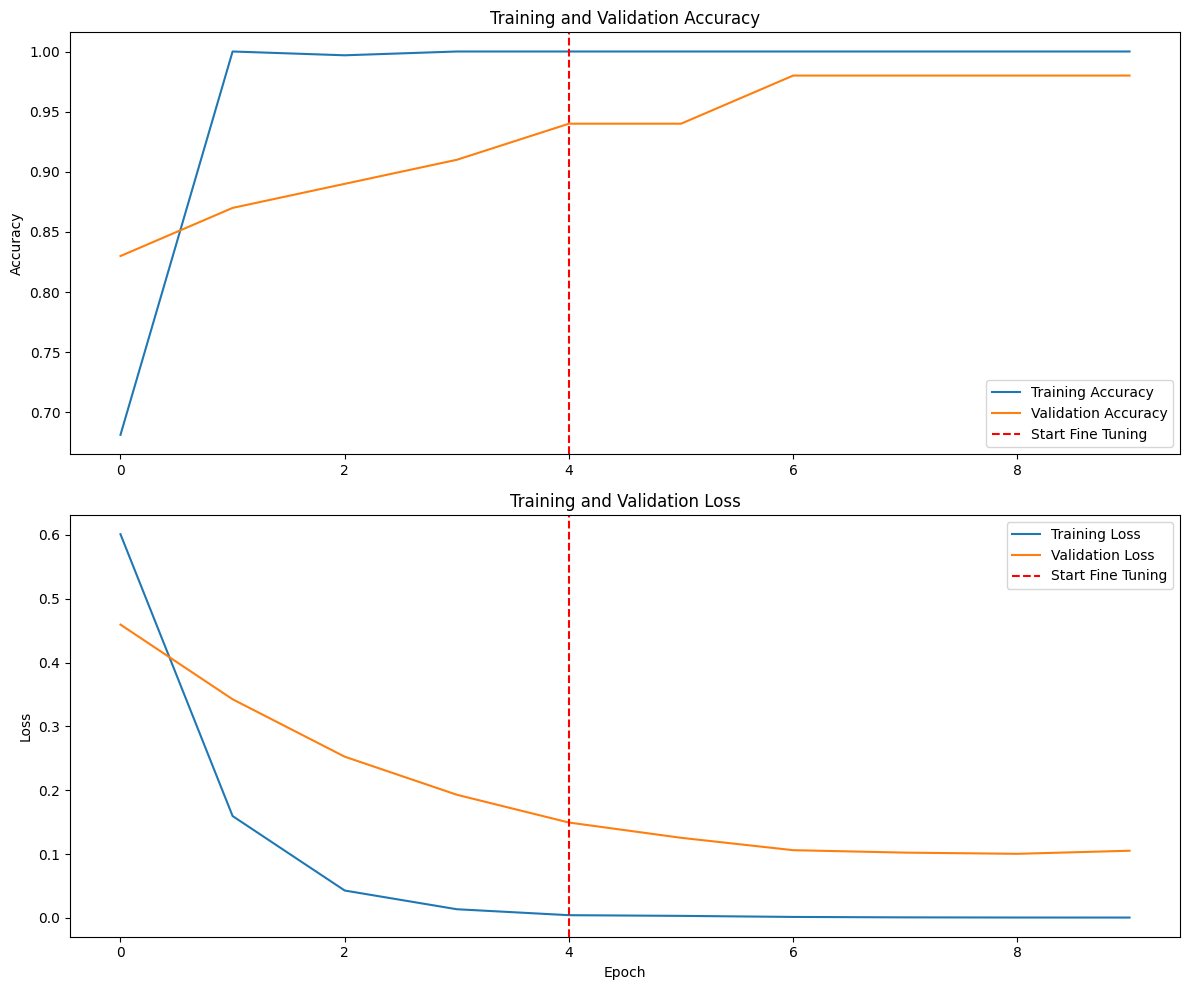

Final Validation Accuracy: 0.98


In [ ]:
import matplotlib.pyplot as plt

# Calcul du nombre total d'époques (entraînement initial + fine-tuning)
total_epochs = num_epochs_initial + num_epochs_finetune

# Affichage des courbes de précision et de perte
plt.figure(figsize=(12, 10))

# Sous-graphe de précision (Accuracy)
plt.subplot(2, 1, 1)
plt.plot(range(total_epochs), train_acc_history, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc_history, label='Validation Accuracy')
plt.axvline(x=num_epochs_initial-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

# Sous-graphe de perte (Loss)
plt.subplot(2, 1, 2)
plt.plot(range(total_epochs), train_loss_history, label='Training Loss')
plt.plot(range(total_epochs), val_loss_history, label='Validation Loss')
plt.axvline(x=num_epochs_initial-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Évaluation du modèle pour obtenir la meilleure précision sur l'ensemble de validation
model.eval()
val_running_corrects = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)

        # Prédictions et calcul de la précision
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5  # Seuil pour la classification binaire
        val_running_corrects += torch.sum(preds == labels.byte())

# Calcul de la précision finale
val_accuracy = val_running_corrects.double() / len(val_dataset)
print('Final Validation Accuracy:', val_accuracy.item())


On obtient une précision encore plus élevée que dans le modèle précédent et une meilleure stabilisation.

Validation accuracy: 0.98
Predictions:
 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


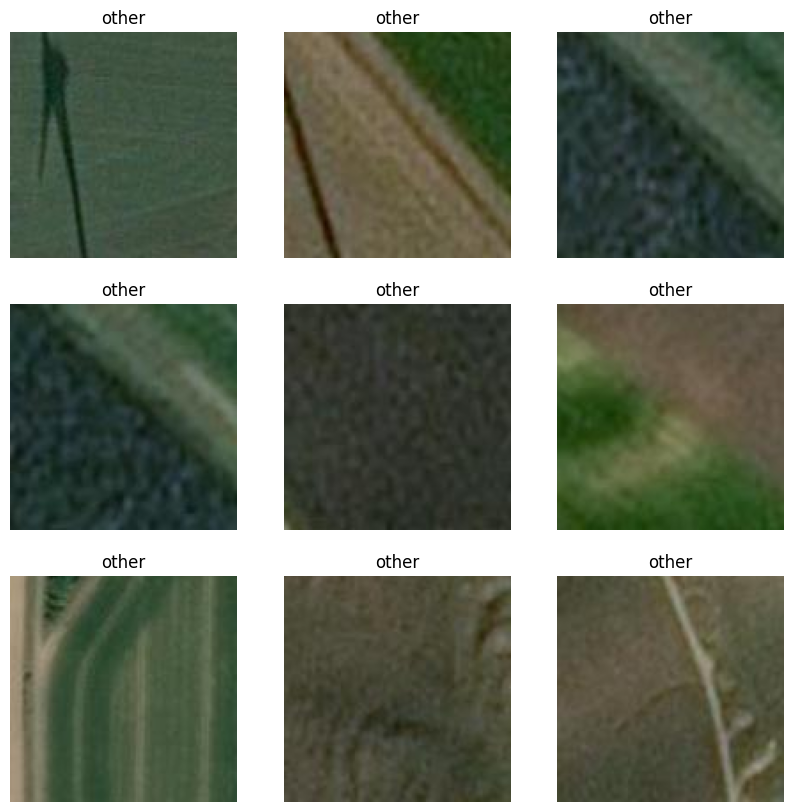

In [ ]:
# Évaluer le modèle sur l'ensemble de validation
model.eval()
val_running_corrects = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5

        val_running_corrects += torch.sum(preds == labels.byte())

val_accuracy = val_running_corrects.double() / len(val_dataset)
print('Validation accuracy:', val_accuracy.item())

# Prédictions sur un lot d'images de validation
inputs, labels = next(iter(val_loader))
inputs = inputs.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs) > 0.5

print('Predictions:\n', preds.cpu().numpy().flatten())
print('Labels:\n', labels.cpu().numpy())

# Affichage des images avec les prédictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = inputs[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Dénormaliser
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(class_names[int(preds[i].item())])
    plt.axis("off")
plt.show()


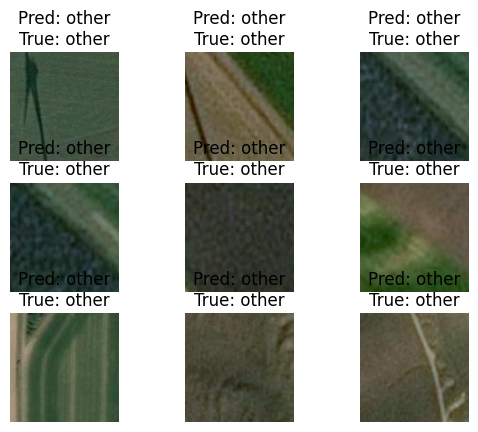

In [ ]:
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = inputs[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    pred_label = class_names[int(preds[i].item())]
    true_label = class_names[int(labels[i].item())]
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()


# 6 Conclusion

Les modèles n'ayant pas tous été testés sur le vrai jeu de données il est difficile de conclure quel est le meilleur modèle. Cependant ResNet50 et EfficientNet B3 semblent plus stables que le modèle MobileNet. Ces 2 modèles ont une meilleure perte et meilleure précision que le mobilenet. Le modèle CNN semble aussi être très efficace.